<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="5">  UE Big Data & Cloud Computing for Oceanography </font></p>
<p></p>
<p><font size="4">  Project: Ocean Warming - Ocean Heat Content </font></p>
<p><font size="4">  Professor: Guillaume MAZE </font></p>
</p></br>
<p><b><font size="4"> Authors: Mohamed MLIKA, Ricardo RODRIGUEZ & Santiago AGUDELO </font></b></p>
</p>
</CENTER>

---------------------------

## Presentation link
This is the link to the shared presentation with the group integrated by Isma Abdelkader Di Carlo and 
Jules Klein

Presentation : https://docs.google.com/presentation/d/1FSId61YvR_7m-DksmwLR0s8tUPMeDQZ-hbdqo-l4cEQ/edit?ts=5e21bbb5#slide=id.p

### Installation and import of different libraries necessary for the project

In [171]:
!pip install jdcal
import sys
import gcsfs
import xarray as xr
import intake
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.pipeline import make_pipeline, make_union
import jdcal
import pandas as pd
from dask_ml.linear_model import LinearRegression as LR
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error

### Import of the database 
We used the packages "zarr" and "xarray" to save the data in the variable $ds$

In [3]:
fs = gcsfs.GCSFileSystem(project="alert-ground-261008")
gcsmap = fs.get_mapper("opendata_bdo2020/EN.4.2.1.f.analysis.g10.zarr")
ds = xr.open_zarr(gcsmap)

The following example shows the temperature distribution of the ocean water at a depth of about $5m$ in may 2010.

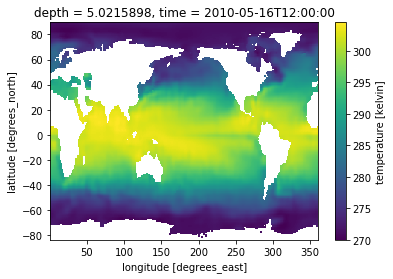

In [4]:
ds['temperature'].sel(time='2010-05').isel(depth=0).plot()

The structure of the dataset is shown below. A point in the dataset is determined by its geographical coordinates (depth, latitude, longitude) as well as its location in time. For each point, a series of variables is available (salinity, temperature, etc.).

In [5]:
ds

<xarray.Dataset>
Dimensions:                          (bnds: 2, depth: 42, lat: 173, lon: 360, time: 832)
Coordinates:
  * depth                            (depth) float32 5.0215898 ... 5350.272
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 1950-01-16T12:00:00 ... 2019-04-16
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    time_bnds                        (time, bnds) datetime64[ns] dask.array<chunksize=(832, 2), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.0
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    GDS_version_id:         v1.7
    contact:                Simon Good - simon.good@metoffice.gov.uk
    creation_date:          2017-04-21 21:12:08.123 -00:00
    easternmost_longitude:  362.5
    file_quality_index:     0
    grid_resolution:           1.00000 degree
    history:                
    institution:            UK Met Office
    netcdf_version_id:      3.5
    northernmost_latitude:  89.5
    product_version:        1.0
    references:             None
    southernmost_latitude:  -90.5
    start_date:             2001-01-01 UTC
    start_time:             00:00:00 UTC
    stop_date:              2001-01-01 UTC
    stop_time:              00:00:00 UTC
    title:                  Temperature and salinity analysis
    westernmost_longitude:  0.5

The following parameters are necessary for our further calculations. $\rho$ stands for the sea water density and $C_p$ for its thermal capacity.

In [6]:
#Parameters
ρ = 1025 #kg/m^3
Cp = 4020 #J/kg.K


OHC calculation requires to determine a volume differential $dV=dx dy dz$. In reality, the integral allowing OHC computation is numerically calculated and it demands the space to be meshed first. The magnitude of differential $dz$ is not uniform and it evolves with respect to the depth. The following figure shows in function of the depth, the difference of two consecutive $z$ points of the mesh. This shows that the mesh in the $z$ axis becomes bigger as the depth increases and it saturates when the depth reaches a value of about $3000m$

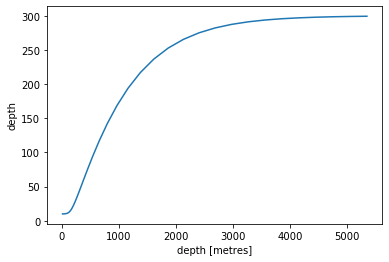

In [7]:
ds['depth'].diff(dim='depth').plot()


The temperature measurement available in the dataset has an associated incertitude. This incertitude's propagation may be used to determine the incertitude in the computed OHC values.

In [59]:
da = ds.copy()
da['temperature_uncertainty']

<xarray.DataArray 'temperature_uncertainty' (time: 832, depth: 42, lat: 173, lon: 360)>
dask.array<zarr, shape=(832, 42, 173, 360), dtype=float32, chunksize=(1, 42, 173, 360), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 5.0215898 15.07854 25.16046 ... 5050.9897 5350.272
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 1950-02-15 ... 2019-04-16
Attributes:
    long_name:  temperature error standard deviation
    units:      kelvin

The radius of the earth is defined as $R$ and it will be used for computing the differentials $dx$ and $dy$

In [60]:
# lat = y , lon = x
# Radius of the Earth
R = 6371*(1000) #meters


In order to determine the length in meters of the different components of the mesh, the following procedure is used. $\alpha$ stands for the / length of an arc which angle equals $1°$. 

In the computation of $dx$ and $dy$, we take into account that the length when moving between two different latitudes doesn't depend on the longitude. However, when moving between two different longitudes, the total distance does depend on the latitude's value (the distance is higher at the equator and it is shorter at the poles). To calculate $dz$, we take into account that the mesh is denser in the surface than in the deeper zones ; therefore, the value of $dz$ becomes larger as the depth increases.

In [114]:
#longitude of an arc of 1°
α = R*(np.pi/180)

#Computation of dy
da['dy'] = α * da['lat'].diff(dim='lat')
da['dy'][0] = da['dy'][1]

#Computation of dx
da['dx'] = np.cos(da['lat']*(np.pi/180))* α *da['lon'].diff(dim='lon')
for i in range(len(da['lat'])):
    da['dx'][i][0] = da['dx'][i][1]

#Computation of ds = dx*dy
da['ds'] = da['dx']*da['dy']

#Computation of dz
dif = xr.zeros_like(da['depth'])
dz = xr.zeros_like(da['depth'])
dif[0] = da['depth'][0]*2
dz[0] = dif[0]
for i in range(len(da['depth'])-1):
    dif[i+1] = (da['depth'][i+1]+(da['depth'][i+1]-dif[i]))
for i in range(1,len(da['depth'])):
    dz[i] = dif[i]-dif[i-1]

da['dz'] = dz

#Computation of dV = ds*dz
da['dV'] = da['dz']*da['ds']


## Computing the total volume
In the following procedure, we compute the sum of the volume differentials we have just extracted. If they have been well determined, this sum should be approximately equal to the volume of the ocean.

In [139]:
da['mask_tem'] = np.invert(np.isnan(ds['temperature'].isel(time=0))) 

The previous mask allows a "binarization" of the earth. This way, we can put zeros in the zone where there is land so we only consider the surface of the earth corresponding to the ocean.

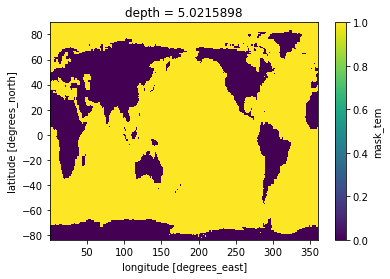

In [140]:
da['mask_tem'].isel(depth=0).plot()

We compute the volume by multipying the volume differential $dV$ by the mask defined previously; this allows taking into account the zones where water is present. Then, the sum of all the water volume differentials is computed and compared to the equivalent volume of ocean water.

In [141]:
vol = (da['mask_tem']*da['dV']).sum('lat').sum('lon')

In [142]:
voltotal = np.array(vol.sum(dim='depth'))

It can be stated that the order of both quantities (computed water volume vs actual water volume) is approximately the same. There is, however, a difference between both values that can be explained by errors in the mask. As it can be seen in the figure above, certain zones which are supposed to be covered by land (Central America, for example) happen to be considered as if they were covered by water. This leads to a greater value of the estimated ocean volume, but still close to the actual one.

In [143]:
voltotal
#1.370 *10^18 m^3

array(1.51412779e+18)

## OHC Calculation
OHC is calculated through the expression $OHC= \rho C_p \int_{V}T(x,y,z)dV$

In [323]:
da['ohc'] = ρ*Cp*(da['dV']*(da['temperature']-273.15)).sel(depth=slice(0,700)).sum(dim=['depth','lat','lon'])
da['ohc2000'] = ρ*Cp*(da['dV']*(da['temperature']-273.15)).sel(depth=slice(700,2000)).sum(dim=['depth','lat','lon'])
da['ohc02000'] = ρ*Cp*(da['dV']*(da['temperature']-273.15)).sel(depth=slice(0,2000)).sum(dim=['depth','lat','lon'])

In [324]:
da['ohc'].load()
da['ohc2000'].load()
da['ohc02000'].load()

<xarray.DataArray 'ohc02000' (time: 832)>
array([1.64516687e+25, 1.64631632e+25, 1.64599285e+25, 1.64801919e+25,
       1.64792628e+25, 1.64333410e+25, 1.64067345e+25, 1.64055418e+25,
       1.64287785e+25, 1.64376823e+25, 1.64166274e+25, 1.64422504e+25,
       1.64725751e+25, 1.64828083e+25, 1.64986717e+25, 1.64869423e+25,
       1.64556247e+25, 1.64484252e+25, 1.64234232e+25, 1.64200080e+25,
       1.64416960e+25, 1.64518841e+25, 1.64638749e+25, 1.64840918e+25,
       1.64824979e+25, 1.64732962e+25, 1.64648487e+25, 1.64408372e+25,
       1.63954712e+25, 1.63679691e+25, 1.63635330e+25, 1.63786039e+25,
       1.63970233e+25, 1.64136786e+25, 1.64020109e+25, 1.64243968e+25,
       1.64583360e+25, 1.64445502e+25, 1.64630289e+25, 1.64482000e+25,
       1.64388641e+25, 1.64091837e+25, 1.63803016e+25, 1.63826662e+25,
       1.64057073e+25, 1.64227848e+25, 1.64246110e+25, 1.64460642e+25,
       1.64637480e+25, 1.64836156e+25, 1.64729141e+25, 1.64756362e+25,
       1.64782519e+25, 1.64264994e+25, 1.64110617e+25, 1.64075096e+25,
       1.64255374e+25, 1.64439892e+25, 1.64415023e+25, 1.64392185e+25,
       1.64415456e+25, 1.64506476e+25, 1.64648658e+25, 1.64512660e+25,
       1.64580776e+25, 1.64001691e+25, 1.63871961e+25, 1.63867902e+25,
       1.63792805e+25, 1.63959977e+25, 1.63568970e+25, 1.63614468e+25,
       1.63958157e+25, 1.64244118e+25, 1.64157563e+25, 1.64076166e+25,
       1.63843592e+25, 1.63651396e+25, 1.63597508e+25, 1.63791222e+25,
       1.63926902e+25, 1.64124732e+25, 1.64392149e+25, 1.64515346e+25,
       1.64573588e+25, 1.64496170e+25, 1.64564933e+25, 1.64255001e+25,
       1.64031525e+25, 1.63725896e+25, 1.63322161e+25, 1.63258693e+25,
       1.63510030e+25, 1.63634446e+25, 1.63818738e+25, 1.64070389e+25,
       1.64180035e+25, 1.64300898e+25, 1.64339665e+25, 1.64617689e+25,
       1.64509213e+25, 1.64050991e+25, 1.63845802e+25, 1.64073298e+25,
       1.63942715e+25, 1.64141867e+25, 1.64182816e+25, 1.64165736e+25,
       1.64299564e+25, 1.64297895e+25, 1.64325435e+25, 1.64290140e+25,
       1.63870177e+25, 1.63713090e+25, 1.63353688e+25, 1.63647258e+25,
       1.63815870e+25, 1.63758004e+25, 1.64088953e+25, 1.64214178e+25,
       1.64120924e+25, 1.64404237e+25, 1.64240098e+25, 1.64396023e+25,
       1.64324519e+25, 1.63798076e+25, 1.63980366e+25, 1.63744816e+25,
       1.64111481e+25, 1.64525382e+25, 1.64403502e+25, 1.63951451e+25,
       1.64407591e+25, 1.64530214e+25, 1.64446277e+25, 1.64095403e+25,
       1.64036591e+25, 1.63731809e+25, 1.63446422e+25, 1.63674557e+25,
       1.63760075e+25, 1.63975515e+25, 1.64139362e+25, 1.64223391e+25,
       1.64362301e+25, 1.64638245e+25, 1.64483471e+25, 1.64106027e+25,
       1.64383328e+25, 1.64332899e+25, 1.64005478e+25, 1.63877479e+25,
       1.64221863e+25, 1.64436279e+25, 1.64145300e+25, 1.64231631e+25,
       1.64300807e+25, 1.64344171e+25, 1.64497488e+25, 1.64644764e+25,
       1.64418441e+25, 1.64177997e+25, 1.63911280e+25, 1.63672566e+25,
       1.63807583e+25, 1.64010050e+25, 1.63957631e+25, 1.64239104e+25,
       1.64279115e+25, 1.64175853e+25, 1.64440464e+25, 1.64553844e+25,
       1.64188086e+25, 1.63783008e+25, 1.63557875e+25, 1.63677353e+25,
       1.63761278e+25, 1.64139553e+25, 1.63935958e+25, 1.63812552e+25,
       1.64042685e+25, 1.64056065e+25, 1.64218369e+25, 1.64120654e+25,
       1.63936687e+25, 1.63692467e+25, 1.63661509e+25, 1.63545569e+25,
       1.63670859e+25, 1.63640066e+25, 1.63748693e+25, 1.64207528e+25,
       1.64182310e+25, 1.64500302e+25, 1.64416290e+25, 1.64269861e+25,
       1.64098257e+25, 1.64092596e+25, 1.63913675e+25, 1.64012613e+25,
       1.64162042e+25, 1.64156995e+25, 1.64033753e+25, 1.64367824e+25,
       1.64695911e+25, 1.64393523e+25, 1.64256736e+25, 1.64489339e+25,
       1.64329208e+25, 1.63958297e+25, 1.63604033e+25, 1.63882855e+25,
       1.63967026e+25, 1.64223975e+25, 1.64337341e+25, 1.64255864e+25,
       1.64022754e+25, 1.63730318e+25, 1.64286640e+25, 1.64255766e+25,
       1.64197484e+25, 1.64133542e+25, 1.64011528e+25

The integral is numerically calculated through the expression 

$OHC = \rho C_p \sum_i T_i dV_i$, where $T_i$ stands for the average temperature of the volume differential $dV_i$.

In order to determine the incertitude of the OHC values we have just calculated, we take into account the following expression:

$\partial OHC = \rho C_p \sqrt{\sum_i[\frac{\partial OHC}{\partial T_i}\partial T_i}]^2= \rho C_p \sqrt{\sum_i[dV_i \partial T_i}]^2$

An upper bound for the incertitude is given by $\partial OHC \leq \rho C_p \sqrt{N} dV_{max} \partial T_{max}$, where $dV_{max}$ and $\partial T_{max}$ stand for the maximum values of the volume differential and the temperature incertitude, respectively. Such bound is calculated in the section below.

In [315]:
um = ρ*Cp*np.sqrt(24*173*360)*5e11*4

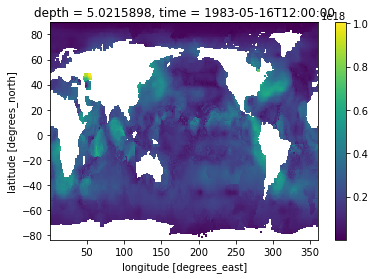

In [146]:
(ρ*Cp*da['dV']*da['temperature_uncertainty']).isel(depth=0).isel(time=400).plot()

In [147]:
da['ohc_uncertainty'] =  np.sqrt(((ρ*Cp*(da['dV']*da['temperature_uncertainty']))*(ρ*Cp*(da['dV']*da['temperature_uncertainty']))).sel(depth=slice(0,700)).sum(dim=['lon','lat','depth']))

In [148]:
da['ohc_uncertainty'].load()

<xarray.DataArray 'ohc_uncertainty' (time: 832)>
array([7.46265905e+20, 7.40511072e+20, 7.50413438e+20, 7.48811590e+20,
       7.50955723e+20, 7.52013234e+20, 7.46807247e+20, 7.42777946e+20,
       7.43947184e+20, 7.47809306e+20, 7.46020632e+20, 7.44678145e+20,
       7.44045785e+20, 7.44246100e+20, 7.41245572e+20, 7.50567470e+20,
       7.53177503e+20, 7.49382823e+20, 7.47714116e+20, 7.44165123e+20,
       7.43974551e+20, 7.44746316e+20, 7.43799070e+20, 7.44393277e+20,
       7.43101569e+20, 7.38323757e+20, 7.39107102e+20, 7.43915483e+20,
       7.42586573e+20, 7.40660241e+20, 7.42853239e+20, 7.43144715e+20,
       7.41155739e+20, 7.39432211e+20, 7.35699545e+20, 7.37088061e+20,
       7.37419726e+20, 7.37815674e+20, 7.39559221e+20, 7.45225845e+20,
       7.44699777e+20, 7.47515586e+20, 7.46378250e+20, 7.48908747e+20,
       7.48128146e+20, 7.46169869e+20, 7.46673644e+20, 7.43018179e+20,
       7.40709848e+20, 7.39895546e+20, 7.39413457e+20, 7.41194683e+20,
       7.45673056e+20, 7.44267765e+20, 7.46243503e+20, 7.45226732e+20,
       7.49200098e+20, 7.46868679e+20, 7.47537808e+20, 7.44339203e+20,
       7.43063047e+20, 7.41727788e+20, 7.32829737e+20, 7.39920156e+20,
       7.43853710e+20, 7.47501881e+20, 7.46555575e+20, 7.58014140e+20,
       7.56002808e+20, 7.48373294e+20, 7.42524334e+20, 7.38836270e+20,
       7.33302402e+20, 7.34967932e+20, 7.34626843e+20, 7.38486155e+20,
       7.36023311e+20, 7.35417495e+20, 7.37616570e+20, 7.31104363e+20,
       7.29962914e+20, 7.31269120e+20, 7.36651190e+20, 7.35915796e+20,
       7.32052329e+20, 7.33934778e+20, 7.28986699e+20, 7.33775646e+20,
       7.36808927e+20, 7.37243678e+20, 7.38476547e+20, 7.39294302e+20,
       7.43235048e+20, 7.49833845e+20, 7.46999022e+20, 7.41235397e+20,
       7.34146182e+20, 7.28136514e+20, 7.29134000e+20, 7.34634769e+20,
       7.34386122e+20, 7.36713942e+20, 7.42734279e+20, 7.52061977e+20,
       7.44017535e+20, 7.43550916e+20, 7.40452436e+20, 7.39282159e+20,
       7.38607954e+20, 7.42380137e+20, 7.42404773e+20, 7.50614418e+20,
       7.52185968e+20, 7.55232752e+20, 7.51040244e+20, 7.52782985e+20,
       7.51123583e+20, 7.45704965e+20, 7.40333730e+20, 7.40910529e+20,
       7.43388302e+20, 7.44584744e+20, 7.43102711e+20, 7.46338450e+20,
       7.48031387e+20, 7.56275019e+20, 7.56469023e+20, 7.54136771e+20,
       7.47630182e+20, 7.43951212e+20, 7.41925873e+20, 7.35350172e+20,
       7.38910745e+20, 7.38298049e+20, 7.38280887e+20, 7.35346308e+20,
       7.32940594e+20, 7.37491441e+20, 7.42451511e+20, 7.48588578e+20,
       7.42368858e+20, 7.38969060e+20, 7.33352135e+20, 7.32950537e+20,
       7.31896560e+20, 7.34281707e+20, 7.39381281e+20, 7.44134012e+20,
       7.46048401e+20, 7.42014280e+20, 7.37758159e+20, 7.40817387e+20,
       7.46532056e+20, 7.46008216e+20, 7.39025632e+20, 7.38534067e+20,
       7.42888746e+20, 7.40422690e+20, 7.44716699e+20, 7.43551291e+20,
       7.48828925e+20, 7.45797079e+20, 7.47226742e+20, 7.36309066e+20,
       7.31051950e+20, 7.28236349e+20, 7.31561426e+20, 7.27939818e+20,
       7.29585273e+20, 7.30480745e+20, 7.37005848e+20, 7.38914141e+20,
       7.39251195e+20, 7.38922216e+20, 7.37982068e+20, 7.41041084e+20,
       7.45369976e+20, 7.40726959e+20, 7.36012241e+20, 7.30944862e+20,
       7.31168294e+20, 7.32117665e+20, 7.35362389e+20, 7.42608411e+20,
       7.38576487e+20, 7.37452343e+20, 7.39020640e+20, 7.40864236e+20,
       7.35098346e+20, 7.30767304e+20, 7.24582638e+20, 7.19191941e+20,
       7.22352245e+20, 7.23924242e+20, 7.28041612e+20, 7.34626206e+20,
       7.31370895e+20, 7.32363197e+20, 7.38231509e+20, 7.38898815e+20,
       7.37193603e+20, 7.42656916e+20, 7.43875500e+20, 7.44707122e+20,
       7.41906490e+20, 7.39936376e+20, 7.37402531e+20, 7.34162783e+20,
       7.35499214e+20, 7.34345104e+20, 7.41805801e+20, 7.38256298e+20,
       7.37459273e+20, 7.34192761e+20, 7.37339029e+20, 7.38139611e+20,
       7.33579429e+20, 7.28478887e+20, 7.31277228e+20, 7.27631832e+20,
       7.32718770e+20, 7.35782697e+20, 7.34800

The OHC mean is calculated between the years 1950 and 2000. 

In [344]:
ohc_mean = (da['ohc']/1e21).sel(time=slice('1950','2000')).mean()
ohc_mean2000 = (da['ohc2000']/1e21).sel(time=slice('1950','2000')).mean()
ohc_mean02000 = (da['ohc02000']/1e21).sel(time=slice('1950','2000')).mean()

The yearly mean is computed in the following section

In [347]:
t = np.array(da['time'].groupby('time.year').mean(dim='time'))
tm = np.array(da['time'].sel(time=slice('1950','2010')).groupby('time.year').mean(dim='time'))

y = np.array((da['ohc']/1e21-ohc_mean).groupby('time.year').mean(dim='time'))
y2000 = np.array((da['ohc2000']/1e21-ohc_mean2000).groupby('time.year').mean(dim='time'))
y02000 = np.array((da['ohc02000']/1e21-ohc_mean02000).groupby('time.year').mean(dim='time'))

# Uncertainty approximation
ym = y-um/1e21
yp = y+um/1e21

# Real Uncertainty
yne = np.array(((da['ohc']-da['ohc_uncertainty']/2)/1e21-ohc_mean).sel(time=slice('1950','2010')).groupby('time.year').mean(dim='time'))
ypo = np.array(((da['ohc']+da['ohc_uncertainty']/2)/1e21-ohc_mean).sel(time=slice('1950','2010')).groupby('time.year').mean(dim='time'))

The following figure shows the global Ocean Heat Content tendency. The results are shown for different intervals of depths; the mean is substracted so only the changements with respect to the mean are explained by the graphic. 

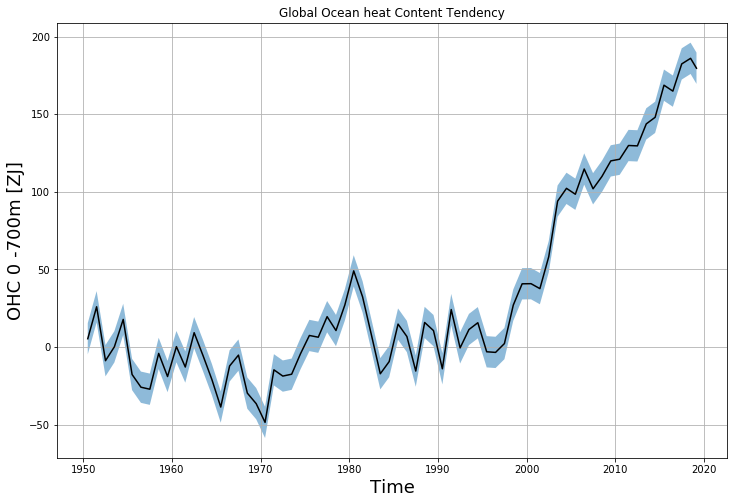

In [328]:
plt.figure(figsize=(12,8))

plt.fill_between(t,ym,yp,alpha=0.5)
plt.plot(t,y,'k')
plt.title('Global Ocean heat Content Tendency',fontsize=20)
plt.ylabel('OHC 0 -700m [ZJ]', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.grid()

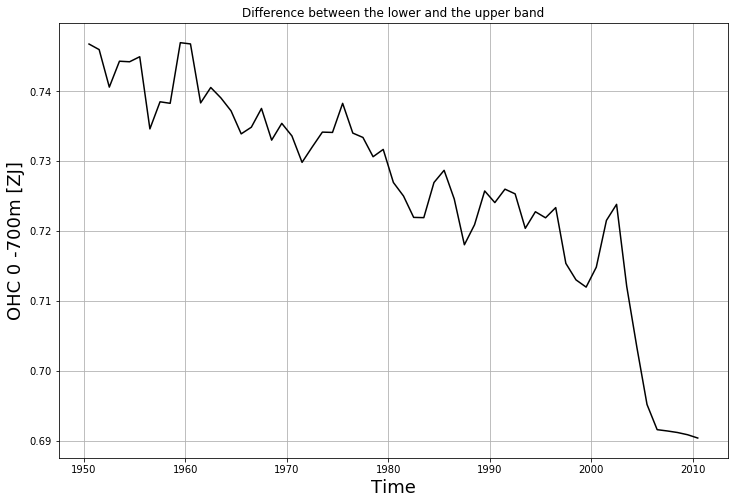

In [351]:
plt.figure(figsize=(12,8))

plt.plot(tm,ypo-yne,'k')
plt.title('Difference between the lower and the upper band', fontsize=20)
plt.ylabel('OHC 0 -700m [ZJ]', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.grid()

Note : the blue bands correspond to the maximum bound of OHC incertitude by taking into account the propagation of the temperature's incertitude in OHC calculation. 
When taking into account the exact calculation of the incertitude by propagating that of the temperature, its order is lower than that of OHC values; therefore, when adding the incertitude to OHC, no great change can be noted. A more precise modeling of different incertitudes in different parameters and variables may lead to a better representation of such bands.
It can be stated, however, when taking into account the exact calculation given by the expression in the section above, that the difference between the bands is lower when the time increases. This is due to the fact that temperature measurements have become more precise and therefore they imply less incertitude, which results in a narrower confidence interval for OHC.

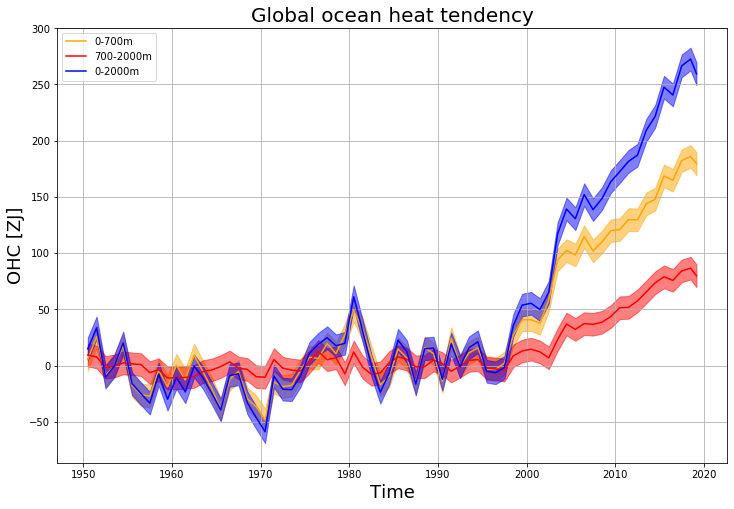

In [352]:
plt.figure(figsize=(12,8))

# OHC between 0-700m
plt.plot(t,y,'orange',label='0-700m')
plt.fill_between(t,ym,yp,color='orange',alpha=0.5)

# OHC between 700-2000m
plt.plot(t,y2000,'red',label='700-2000m')
plt.fill_between(t,y2000-um/1e21,y2000+um/1e21,color='red',alpha=0.5)

# OHC between 0-2000m
plt.plot(t,y02000,'blue',label='0-2000m')
plt.fill_between(t,y02000-um/1e21,y02000+um/1e21,color='blue',alpha=0.5)

plt.title('Global ocean heat tendency', fontsize=20)
plt.ylabel('OHC [ZJ]', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend()
plt.grid()

When varying the depths in which the OHC is computed, it can be seen that the deeper zones of the ocean have been concerned by a lower increase of the heat content during the last few decades, while this augmentation has been higher for the zones which are closer to the surface. 
This graphic shows that different conclusions may be drawn with respect to the considered depths; however, it can be seen that for every considered set the trend is clear, and it shows an augmentation of OHC in recent years.

## OHC Prediction

The time vectors for the prediction models are created

In [165]:
tp = pd.to_datetime(pd.to_datetime(t)).to_julian_date()
t2 = np.arange('2020-01', '2050-12', dtype='datetime64[D]')
tpd = np.concatenate([t, t2])
tp2 = pd.to_datetime(pd.to_datetime(t2)).to_julian_date()
tpx = np.concatenate([tp, tp2])

The following section correspond to an SVR (support vector regression) implementation. The resulting model is non-linear.

In [166]:
# specify epsilon: the half-width of the "corridor" of data around the fitted line
epsilon = 0.5
C = 50

# set up a generic instance of the model
model=SVR(C=C, epsilon=epsilon, degree=3,kernel='rbf')
# C is the "regularisation" term: this stops
# the model from becoming too complicated (overfitting)
# smaller C gives stronger regularisation (i.e. a simpler model)

# fit the model
model.fit(tp[:,None],y)

# and predict values of ŷ
y_svr = model.predict(tpx[:,None])

This section corresponds to a polynomial regression which allows predicting the behavior of OHC. We chose a degree 4 polynomial to interpolate our data.

In [167]:
polynomial_features= PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(tp[:,None])
model2 = LinearRegression()

# fit the model
model2.fit(x_poly, y)
x_poly = polynomial_features.fit_transform(tpx[:,None])

# and predict values of ŷ
y_poly = model2.predict(x_poly)

This section corresponds to a Kernel Ridge based regression, which combines Ridge regression and classification (linear least squares with l2-norm regularization) with the kernel trick. It thus learns a linear function in the space induced by the respective kernel and the data. 

In [170]:
reg = KernelRidge(alpha=0.1,kernel='rbf')
reg.fit(tp[:,None],y)

y_pred = reg.predict(tp[:,None])
y_pred[len(y_pred):len(y_svr)] = y_pred[-1]
y_krr = np.zeros(len(y_svr))
y_krr[0:len(y_pred)] = y_pred[0:len(y_pred)]
y_krr[len(y_pred):len(y_krr)] = y_pred[-1]

The following quantities stand for the fraction of each model that will be taken into account when computing a compound model, which will be nothing but a linear ponderation of the three different considered models.

In [172]:
f_poly = 1/3
f_svr = 1/3
f_krr = 1/3

The mean square error is computed for all the previously considered models.

In [177]:
mse = mean_squared_error(y, y_svr[0:len(y)])
mse2 = mean_squared_error(y, y_poly[0:len(y)])

# Compound model
y_com = (y_poly*f_poly+y_svr*f_svr+y_krr*f_krr)
mse3 = mean_squared_error(y, y_com[0:len(y)])

The different models as well as a 90\% confidence interval for each one of them are plotted in the section below.

Text(0.5, 1.0, 'Global Ocean heat Content Tendency Horizon 2050')

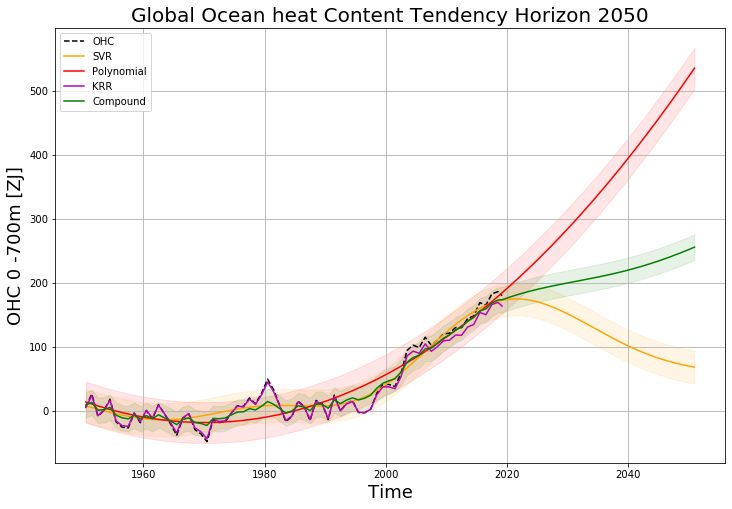

In [184]:

plt.figure(figsize=(12,8))

# plot the results
plt.plot(t,y,'k--',label='OHC')

#SVR model
plt.plot(tpd,y_svr,'orange',label='SVR')
plt.fill_between(tpd, y_svr - 1.645 * np.sqrt(mse), y_svr + 1.645 * np.sqrt(mse),color='orange', alpha=0.1)

# Polynomial model
plt.plot(tpd,y_poly,'red',label='Polynomial')
plt.fill_between(tpd, y_poly - 1.645 * np.sqrt(mse2), y_poly + 1.645 * np.sqrt(mse2),color='red', alpha=0.1)

# Kernel Ridege model
plt.plot(t,y_pred,'m',label='KRR')

# Compound model
plt.plot(tpd,y_com,'green',label='Compound')
plt.fill_between(tpd, y_com - 1.645 * np.sqrt(mse3), y_com + 1.645 * np.sqrt(mse3),color='green', alpha=0.1)

plt.legend()
plt.ylabel('OHC 0 -700m [ZJ]', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.grid()
plt.title('Global Ocean heat Content Tendency Horizon 2050',fontsize=20)



## OHCZ
The metric OHCZ stands for the integral of the temperature only along the depth $z$. OHCZ is therefore a function of the coordinates $x$ and $y$ and is given by the expression: 

$OHCZ(x,y)= \rho C_p \int_z T(x,y,z) dz$

In [185]:
da['ohcz'] = ρ*Cp*(da['dz']*(da['temperature']-273.15)).sum(dim='depth')

In [186]:
da['ohcz'].load()

<xarray.DataArray 'ohcz' (time: 832, lat: 173, lon: 360)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-8.09672436e+09, -8.08921054e+09, -8.07512855e+09, ...,
         -8.17848835e+09, -8.16442768e+09, -8.11359302e+09],
        [-8.40109165e+09, -8.40054973e+09, -8.39582542e+09, ...,
         -9.31381949e+09, -9.30611449e+09, -8.40630153e+09],
        [-8.41565090e+09, -8.41171278e+09, -8.40550335e+09, ...,
         -9.33238528e+09, -9.32645458e+09, -8.42065252e+09]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-8.28998695e+09, -8.27935864e+09, -8.26258357e+09, ...,
         -8.36742234e+09, -8.35364556e+09, -8.30225149e+09],
        [-8.58692441e+09, -8.58877598e+09, -8.58540019e+09, ...,
         -9.50065087e+09, -9.49330851e+09, -8.59086957e+09],
        [-8.57010876e+09, -8.56738602e+09, -8.56207449e+09, ...,
         -9.48901718e+09, -9.48326979e+09, -8.57427660e+09]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-8.13463019e+09, -8.14859894e+09, -8.15034564e+09, ...,
         -8.21255825e+09, -8.19870020e+09, -8.14682073e+09],
        [-8.46980384e+09, -8.46799212e+09, -8.46335406e+09, ...,
         -9.38633582e+09, -9.37799607e+09, -8.47482040e+09],
        [-8.51043381e+09, -8.50659255e+09, -8.50088962e+09, ...,
         -9.42911505e+09, -9.42336479e+09, -8.51486854e+09]],

       ...,

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-6.57018606e+09, -6.52207649e+09, -6.49252673e+09, ...,
         -6.68396722e+09, -6.65791673e+09, -6.59423430e+09],
        [-7.07208641e+09, -7.04967732e+09, -7.03839775e+09, ...,
         -8.01032992e+09, -7.99478781e+09, -7.08404256e+09],
        [-7.31074006e+09, -7.29832689e+09, -7.29037196e+09, ...,
         -8.23967892e+09, -8.23031132e+09, -7.31810865e+09]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-6.81530861e+09, -6.80173704e+09, -6.79399272e+09, ...,
         -6.91863382e+09, -6.89631828e+09, -6.83578411e+09],
        [-7.27571796e+09, -7.25502887e+09, -7.24421207e+09, ...,
         -8.21076154e+09, -8.19625916e+09, -7.28665929e+09],
        [-7.49036702e+09, -7.47878677e+09, -7.47093046e+09, ...,
         -8.41704780e+09, -8.40839805e+09, -7.49724535e+09]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         

The following example shows the OHCZ in 1950, the instant $t=0$ of our time series. Since each point shows the temperature integral along the $z$ axis, the higher the value represented in the plot, the higher the average temperature along the $z$ axis at this point is. 

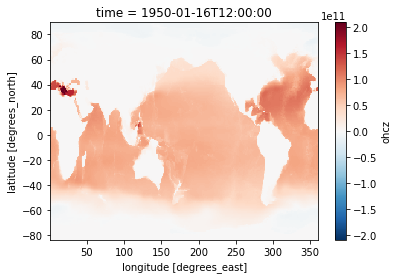

In [187]:
(da['ohcz']).isel(time=0).plot()

In [190]:
dm = da['ohcz']
dm

<xarray.DataArray 'ohcz' (time: 832, lat: 173, lon: 360)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-8.09672436e+09, -8.08921054e+09, -8.07512855e+09, ...,
         -8.17848835e+09, -8.16442768e+09, -8.11359302e+09],
        [-8.40109165e+09, -8.40054973e+09, -8.39582542e+09, ...,
         -9.31381949e+09, -9.30611449e+09, -8.40630153e+09],
        [-8.41565090e+09, -8.41171278e+09, -8.40550335e+09, ...,
         -9.33238528e+09, -9.32645458e+09, -8.42065252e+09]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-8.28998695e+09, -8.27935864e+09, -8.26258357e+09, ...,
         -8.36742234e+09, -8.35364556e+09, -8.30225149e+09],
        [-8.58692441e+09, -8.58877598e+09, -8.58540019e+09, ...,
         -9.50065087e+09, -9.49330851e+09, -8.59086957e+09],
        [-8.57010876e+09, -8.56738602e+09, -8.56207449e+09, ...,
         -9.48901718e+09, -9.48326979e+09, -8.57427660e+09]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-8.13463019e+09, -8.14859894e+09, -8.15034564e+09, ...,
         -8.21255825e+09, -8.19870020e+09, -8.14682073e+09],
        [-8.46980384e+09, -8.46799212e+09, -8.46335406e+09, ...,
         -9.38633582e+09, -9.37799607e+09, -8.47482040e+09],
        [-8.51043381e+09, -8.50659255e+09, -8.50088962e+09, ...,
         -9.42911505e+09, -9.42336479e+09, -8.51486854e+09]],

       ...,

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-6.57018606e+09, -6.52207649e+09, -6.49252673e+09, ...,
         -6.68396722e+09, -6.65791673e+09, -6.59423430e+09],
        [-7.07208641e+09, -7.04967732e+09, -7.03839775e+09, ...,
         -8.01032992e+09, -7.99478781e+09, -7.08404256e+09],
        [-7.31074006e+09, -7.29832689e+09, -7.29037196e+09, ...,
         -8.23967892e+09, -8.23031132e+09, -7.31810865e+09]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-6.81530861e+09, -6.80173704e+09, -6.79399272e+09, ...,
         -6.91863382e+09, -6.89631828e+09, -6.83578411e+09],
        [-7.27571796e+09, -7.25502887e+09, -7.24421207e+09, ...,
         -8.21076154e+09, -8.19625916e+09, -7.28665929e+09],
        [-7.49036702e+09, -7.47878677e+09, -7.47093046e+09, ...,
         -8.41704780e+09, -8.40839805e+09, -7.49724535e+09]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         

We want to analyze the trend of OHC in the different zones of the world. Ideally, one should consider a time series for each one of the points of the map corresponding to ocean water and perform a regression of OHCZ. Even though this is feasible, it would be ressource and time-consuming. 

A (very) simplified way to analyze the trend is to compute the mean OCHZ in two different decades (in this case, we considered the 1990s and the 2010s decades) and to compute the total change in this mean within the corresponding time period. This is : 

$Slope(x,y) = \frac{OCHZ(x,y,t)-OCHZ(x,y,t+T)}{T}$, where $T$ corresponds to the time period between the considered decades (20 years in our case). When considering the time units are given in seconds, the slope's unities are $J/m^2$


In [307]:
dm['mean_90_00'] = dm.sel(time=slice('1990','2000')).mean(dim='time')
dm['mean_10_20'] = dm.sel(time=slice('2010','2020')).mean(dim='time')
dm['slope'] = (dm['mean_10_20']-dm['mean_90_00'])/(20*365.2*3600*24)

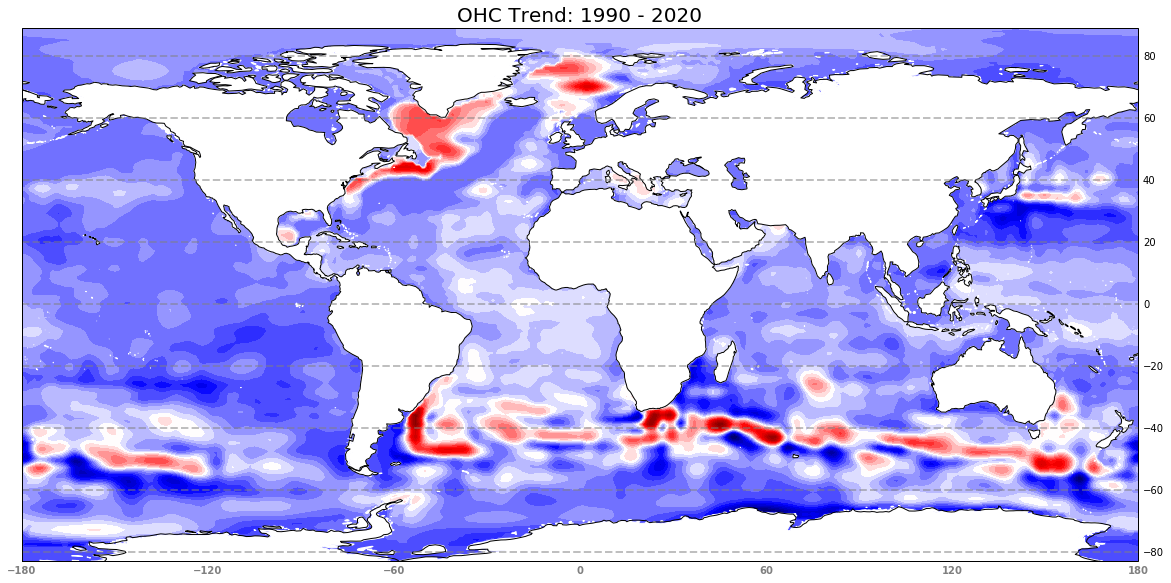

In [306]:
import cartopy.feature as cfeature
from cartopy import config
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

data, lon = add_cyclic_point(dm['slope'].values, coord=dm['lon'].values)
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title('OHC Trend: 1990 - 2020',fontsize=20)
plt.contourf(lon, dm['lat'].values, data, transform=ccrs.PlateCarree(),levels=30,cmap='seismic')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='w'))
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = False

gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
plt.show()

The previous figure shows the values of the slope computed between the indicated decades. A high value of the slope indicates a high increase in the OCHZ value which is equivalent to a high increase in the mean temperature along the $z$ axis. The zones in blue are zones in which the slope is negative and, therefore, the zones in which the mean temperature of the ocean has decreased.

## Longitude analysis

It is possible to perform a similar anaylisis but calculating an OHC index but this time by computing an integral with respect to the longitude. In such case, the OHC indicator would be a function of the depth and the latitude. 

The following section shows a first step into such approach; however, it wasn't completed. Nevertheless, this sets up some perspective and may motivate future work on this subject.

In [275]:
ds_test['ohcx'] = ρ*Cp*(ds_test['dx']*(ds['temperature']-273.15)).sel(depth=slice(0,700)).sum(dim='lon')

In [332]:
ds_test['dx']

<xarray.DataArray 'dx' (lat: 173, lon: 360)>
array([[13551.251 , 13551.251 , 13551.251 , ..., 13551.251 , 13551.251 ,
        13551.251 ],
       [15475.344 , 15475.344 , 15475.344 , ..., 15475.344 , 15475.344 ,
        15475.344 ],
       [17394.723 , 17394.723 , 17394.723 , ..., 17394.723 , 17394.723 ,
        17394.723 ],
       ...,
       [ 5819.495 ,  5819.495 ,  5819.495 , ...,  5819.495 ,  5819.495 ,
         5819.495 ],
       [ 3880.647 ,  3880.647 ,  3880.647 , ...,  3880.647 ,  3880.647 ,
         3880.647 ],
       [ 1940.6166,  1940.6166,  1940.6166, ...,  1940.6166,  1940.6166,
         1940.6166]], dtype=float32)
Coordinates:
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... 86.0 87.0 88.0 89.0

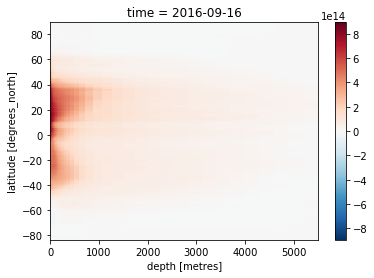

In [355]:
(ρ*Cp*(ds_test['dx']*(ds['temperature']-273.15))).sel(lon=slice(277,360)).sum(dim='lon').isel(time=800).plot()


In [ ]:
(ρ*Cp*(ds_test['dx']*(ds['temperature']-273.15))).sel

In [276]:
ds_test['ohcx'].load()

<xarray.DataArray 'ohcx' (lat: 173, time: 832, depth: 42)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan]],

       [[-7.58265355e+10,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        [-8.58423926e+10,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        [-9.70262988e+10,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        ...,
        [-8.19511035e+10,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        [-9.35243566e+10,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan],
        [-9.38218294e+10,  0.00000000e+00,  0.00000000e+00, ...,
                     nan,             nan,             nan]],

       ...,

       [[-1.51992688e+13, -1.56948702e+13, -1.61667869e+13, ...,
                     nan,             nan,             nan],
        [-1.57851256e+13, -1.65826875e+13, -1.69953968e+13, ...,
                     nan,             nan,             nan],
        [-1.37012404e+13, -1.52087820e+13, -1.55836857e+13, ...,
                     nan,             nan,             nan],
        ...,
        [-8.75893552e+12, -9.82042679e+12, -8.83582199e+12, ...,
                     nan,             nan,             nan],
        [-8.52435442e+12, -1.03078902e+13, -9.44209073e+12, ...,
                     nan,             nan,             nan],
        [-7.53330258e+12, -1.06984724e+13, -9.95532990e+12, ...,
                     nan,             nan,             nan]],

       [[-9.48814452e+12, -1.03428300e+13, -1.06418021e+13, ...,
                     nan,             nan,             nan],
        [-9.84208002e+12, -1.09139436e+13, -1.11529759e+13, ...,
                     nan,             nan,             nan],
        [-8.20571410e+12, -1.00107486e+13, -1.02201483e+13, ...,
                     nan,             nan,             nan],
        ...,
        [-5.33106530e+12, -6.52512542e+12, -5.84283295e+12, ...,
                     nan,             nan,             nan],
        [-4.86708927e+12, -6.80634388e+12, -6.19714341e+12, ...,
                     nan,             nan,             nan],
        [-3.64930177e+12, -7.05485072e+12, -6.52996959e+12, ...,
                     nan,             nan,             nan]],

       [[-4.73070536e+12, -5.16483506e+12, -5.31044065e+12, ...,
        

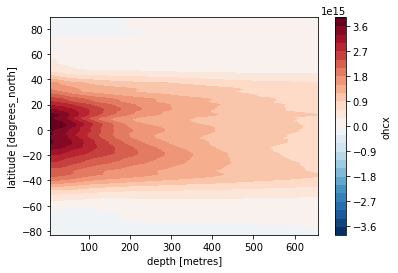

In [296]:
(ds_test['ohcx']).sel(depth=slice(0,700)).mean(dim='time').plot.contourf(levels=30)